<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
#added other imports to support this notebook

import itertools
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score, log_loss

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2020-11-02 13:46:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2020-11-02 13:46:49 (268 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Let’s see how many of each class is in our data set 


# Data visualization and pre-processing


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

# I have run the install with conda once, replaced it afterwards with a pip call quicker install and because it detects if seaborn is already there
# and omits the install when it's unnecesary

!pip install seaborn
import seaborn as sns

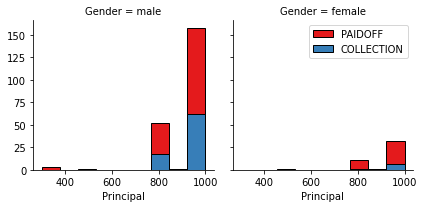

In [8]:
# make a histrogram on PAIDOFF / COLLECTION based on principal of the loan
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

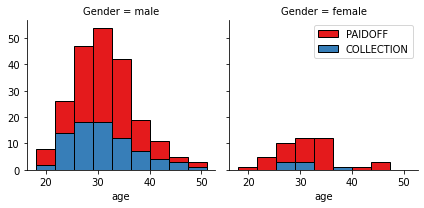

In [9]:
# make a histrogram on PAIDOFF / COLLECTION based on the gender

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


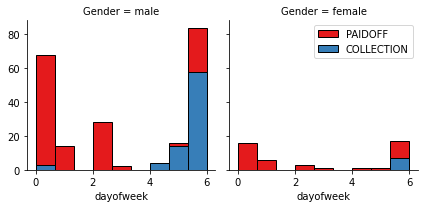

In [10]:
# histogram on day of the week

df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
# we define weekend as Friday - Sunday
# use lambda to define the function of x on the fly

df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
# groupby gender and normalize based on % of total

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
# let's ignore the typo (Bechalor = Bachelor), but normalize to get a quick view on the data
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
# let's see the first 5 rows of X
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
# preprocess the data to make the ML estimators work better

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
# split into 80-20 train / test with random state 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# if you'd like to see the first 5 rows of X_train and y_train, uncomment the next two lines
#print(X_train[0:5])
#print(y_train[0:5])

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

# let's prepare our results DF
d = {'Algorithm':['KNN','Decision Tree','SVM','LogisticRegression'],\
    'Jaccard':[np.NaN,np.NaN,np.NaN,np.NaN],\
    'F1_score':[np.NaN,np.NaN,np.NaN,np.NaN],\
    'LogLoss':[np.NaN,np.NaN,np.NaN,np.NaN]}
df_train = pd.DataFrame(data=d)
df_train.set_index('Algorithm', inplace=True)

# and make a copy af that df for the final results
df_fin = df_train.copy()

# define a function to store the results later on

def store_results(df, algo, y_test, yhat, yhat2=None):
    #f_1 = round(f1_score(y_test, yhat, average='weighted'),4)
    #jaccard = round(jaccard_score(y_test, yhat, pos_label='PAIDOFF'),4)
    #ll = round(log_loss(y_test, yhat),4)
    df.loc[algo]['Jaccard']=round(jaccard_score(y_test, yhat, pos_label='PAIDOFF'),4)
    df.loc[algo]['F1_score']=round(f1_score(y_test, yhat, average='weighted'),4)
    if algo == 'LogisticRegression':
        df.loc[algo]['LogLoss']=round(log_loss(y_test, yhat2),4)

# define the function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
from sklearn.neighbors import KNeighborsClassifier

# let's start with k = 6 to get a first view
neigh6 = KNeighborsClassifier(n_neighbors = 6).fit(X_train, y_train)

print('Train set Accuracy: ', metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, neigh6.predict(X_test)))

Train set Accuracy:  0.8007246376811594
Test set Accuracy:  0.7142857142857143


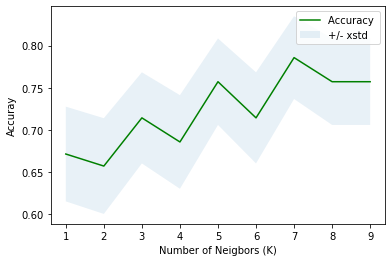

The best accuracy was with 0.7857142857142857 with k= 7
              precision    recall  f1-score   support

  COLLECTION       0.50      0.40      0.44        15
     PAIDOFF       0.84      0.89      0.87        55

    accuracy                           0.79        70
   macro avg       0.67      0.65      0.66        70
weighted avg       0.77      0.79      0.78        70

Confusion matrix, without normalization
[[ 6  9]
 [ 6 49]]
                    Jaccard  F1_score  LogLoss
Algorithm                                     
KNN                  0.7656    0.7767      NaN
Decision Tree           NaN       NaN      NaN
SVM                     NaN       NaN      NaN
LogisticRegression      NaN       NaN      NaN


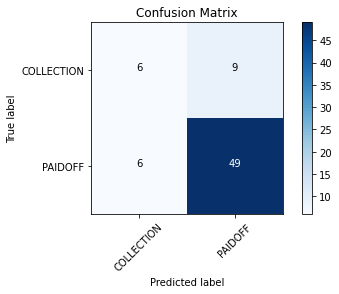

In [22]:
# Let's dive into finding the 'best' K
# Prepare the variables we need to store the result
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
#ConfusionMx = []

# Train the Kn model and capture the results in the result variables
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
# Now let's plot the accuracy for different Ks
plt.plot(range(1,Ks), mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha =0.10)
plt.legend(('Accuracy ', '+/- xstd'))
plt.ylabel('Accuray')
plt.xlabel('Number of Neigbors (K)')
plt.tight_layout
plt.show()

# store the best k
k_best = mean_acc.argmax()+1

# and print the K with the best accuracy
print('The best accuracy was with',mean_acc.max(), 'with k=',k_best)

neigh = KNeighborsClassifier(n_neighbors = k_best).fit(X_train,y_train)
yhat = neigh.predict(X_test)

cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize=False, title='Confusion Matrix')

#now store the of the test data
store_results(df_train,'KNN',y_test, yhat)
print(df_train)


# Decision Tree


In [23]:
# import the decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from six import StringIO

!pip install graphviz
!pip install pydotplus

# import libraries for plotting
import pydotplus
import matplotlib.image as mpimg

# import libraries for cross validation
from sklearn.model_selection import cross_val_score

# Install pydotplus and graphviz libraries, both libraries are not compatible with python 3.7
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

DecisionTrees's Accuracy (first try with max_depth = 4):  0.6142857142857143


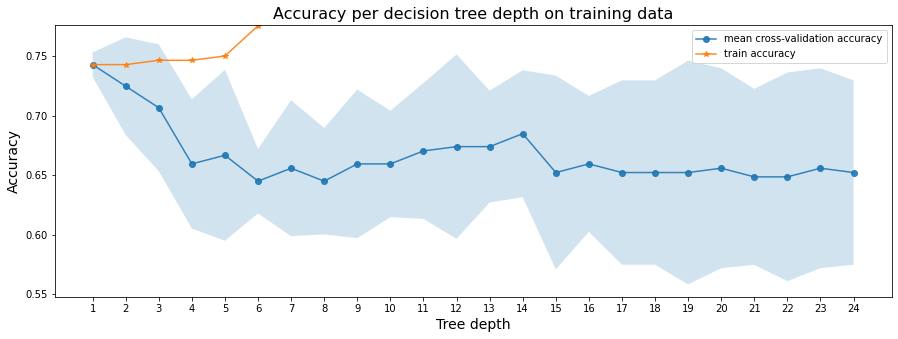

In [24]:
# now let's model the decision tree with a depth of 4
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=4)

# train it our train set
dtree.fit(X_train,y_train)
predTree = dtree.predict(X_test)
print("DecisionTrees's Accuracy (first try with max_depth = 4): ", metrics.accuracy_score(y_test, predTree))

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=3, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

The best accuracy was with 0.7857142857142857 with d = 1
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


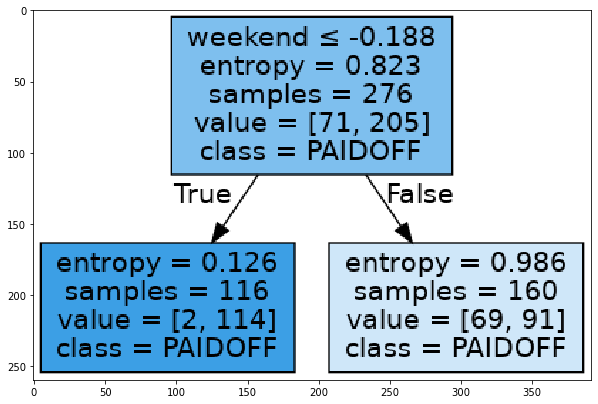

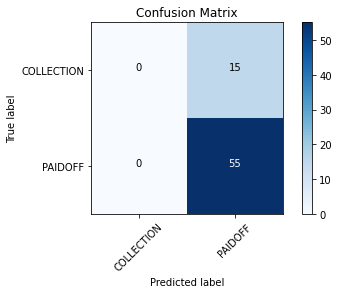

In [25]:
# It looks like the Decision Tree is best with max_depth = 1
# Prepare the variables we need to store the result to double check this result
Ds = 10
mean_acc = np.zeros((Ds-1))
std_acc = np.zeros((Ds-1))

# Train the Depths in the model and capture the results in the result variables
for n in range(1,Ds):
    max_d = n
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=max_d).fit(X_train,y_train)
    predTree = dtree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, predTree)
    std_acc[n-1] = np.std(predTree==y_test)/np.sqrt(predTree.shape[0])

# and print the Depth with the best accuracy
print('The best accuracy was with',mean_acc.max(), 'with d =',mean_acc.argmax()+1)

max_depth = mean_acc.argmax()+1

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth).fit(X_train,y_train)
yhat = dtree.predict(X_test)

# and let's plot the decision tree
dot_data = StringIO()
filename = "dtree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(dtree, feature_names=featureNames, \
                         out_file=dot_data, class_names=np.unique(y_train), filled=True, special_characters=True, rotate = False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(10,20))
plt.imshow(img,interpolation='nearest')

cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize=False, title='Confusion Matrix')

#now store the of the test data
store_results(df_train,'Decision Tree', y_test, yhat)
#print(df_train)

# Support Vector Machine


In [26]:
#import libraries
from sklearn import svm

In [27]:
# define a function to train the SVM and print the results
results = []
f_1s = np.zeros(4)
jaccards = np.zeros(4)

def run_svm(kernel_input, index=None):
    # now let's have a first go at the SVM
    clf = svm.SVC(kernel=kernel_input).fit(X_train, y_train)
    yhat=clf.predict(X_test)

    f_1 = round(f1_score(y_test, yhat, average='weighted'),4)
    jaccard = round(jaccard_score(y_test, yhat, pos_label='PAIDOFF'),4)
    
    #only store the results if we are looping through a list of kernels (ie index is given)
    if index!=None:
        f_1s[index]=f_1
        jaccards[index]=jaccard
        results.append([kernel_input,f_1,jaccard])
    return yhat
    
# run the 4 types of kernels
kernels=['linear','poly','rbf','sigmoid']
index = 0
for kernel in kernels:
    run_svm(kernel,index)
    index = index +1

# find the max avg f_1
print("Best Avg F1 score:", f_1s.max(), " with model:", results[f_1s.argmax()])

kernel_best = results[f_1s.argmax()][0]
#run again with the best setup

clf = svm.SVC(kernel=kernel_best).fit(X_train, y_train)
yhat = clf.predict(X_test)

Best Avg F1 score: 0.7276  with model: ['rbf', 0.7276, 0.7273]


              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


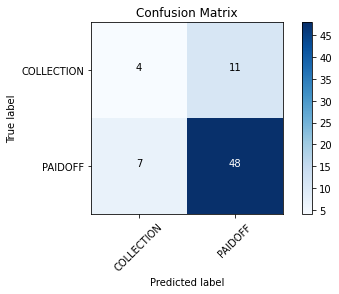

In [28]:
# Compute the confusion matrix and plot it
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize=False, title='Confusion Matrix')

#store the results in de df_test
store_results(df_train,'SVM',y_test, yhat)
#print(df_train)

# Logistic Regression


In [29]:
# import the libraries
from sklearn.linear_model import LogisticRegression


In [30]:
# let's try some solvers
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
yhat = LR.predict(X_test)

LogLoss: : 0.58
              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]
                    Jaccard  F1_score  LogLoss
Algorithm                                     
KNN                  0.7656    0.7767      NaN
Decision Tree        0.7857    0.6914      NaN
SVM                  0.7273    0.7276      NaN
LogisticRegression   0.6765    0.6671   0.5772


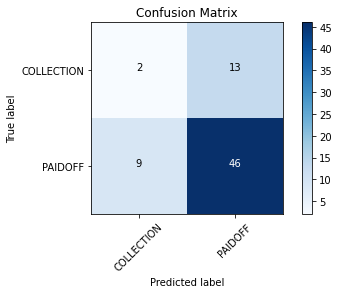

In [31]:

#LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))

# Compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize=False, title='Confusion Matrix')

#store the results in de df_test
store_results(df_train,'LogisticRegression',y_test,yhat,yhat_prob2)
print(df_train)

# Model Evaluation using Test set


In [32]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-02 13:47:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-02 13:47:02 (43.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [34]:
df_test = pd.read_csv('loan_test.csv')
print(df_test.head())
df_test.shape

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30       9/8/2016   
1           5             5     PAIDOFF        300      7       9/9/2016   
2          21            21     PAIDOFF       1000     30      9/10/2016   
3          24            24     PAIDOFF       1000     30      9/10/2016   
4          35            35     PAIDOFF        800     15      9/11/2016   

    due_date  age             education  Gender  
0  10/7/2016   50              Bechalor  female  
1  9/15/2016   35       Master or Above    male  
2  10/9/2016   43  High School or Below  female  
3  10/9/2016   26               college    male  
4  9/25/2016   29              Bechalor    male  


(54, 10)

In [35]:
# we need to do the same pre-processing as with the training / test set
df_test['due_date'] = pd.to_datetime(df_test['due_date'])
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df_test['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_test = df_test[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(df_test['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

X_fin = Feature_test
X_fin = preprocessing.StandardScaler().fit(X_fin).transform(X_fin)
y_fin = df_test['loan_status'].values

# print the results to check the pre-processing
print(X_fin[0:5])
print(y_fin[0:5])
print(X_fin.shape)
print(y_fin.shape)

[[ 0.49  0.93  3.06  1.98 -1.3   2.4  -0.8  -0.86]
 [-3.56 -1.7   0.53 -0.51  0.77 -0.42 -0.8  -0.86]
 [ 0.49  0.93  1.88  1.98  0.77 -0.42  1.25 -0.86]
 [ 0.49  0.93 -0.98 -0.51  0.77 -0.42 -0.8   1.16]
 [-0.67 -0.79 -0.48 -0.51  0.77  2.4  -0.8  -0.86]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54, 8)
(54,)


In [36]:
# get the scoring from the models with the test set
# KNN results based on the trained model neigh
yhat_fin = neigh.predict(X_fin)
store_results(df_fin,'KNN',y_fin, yhat_fin)

# Decision tree
yhat_fin = dtree.predict(X_fin)
store_results(df_fin,'Decision Tree',y_fin, yhat_fin)

# SVM
yhat_fin = clf.predict(X_fin)
store_results(df_fin,'SVM',y_fin, yhat_fin)

# LogisticRegression
yhat_fin = LR.predict(X_fin)
yhat_fin_prob2 = LR.predict_proba(X_fin)
store_results(df_fin,'LogisticRegression',y_fin, yhat_fin, yhat_fin_prob2)

In [37]:
# print the result
df_fin

,Jaccard,F1_score,LogLoss
Algorithm,,,
KNN,0.6538,0.6328,NaN
Decision Tree,0.7407,0.6304,NaN
SVM,0.7800,0.7584,NaN
LogisticRegression,0.7358,0.6604,0.5672


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
